# Engine Crank Patterns and State-of-Charge
## Sam Ashcroft

***

## CONTENTS

### 1. Introduction to Engine Crank Patterns
1. Engine Crank Definitions and Terminology  
2. Relation of Voltage to Engine Crank   
3. Engine Crank Patterns  

### 2. Summarise the Data and Identify Engine Crank Patterns (Q1+Q2)
1. Overview  
    1.1. Variables Available  
    1.2. Measurements per Vehicle  
    1.3. Assumptions  
2. Common Patterns - Engine Crank
3. Common Patterns - Voltage
4. False Positive Engine Cranks  
    4.1. Incorrect Recordings  
    4.2. Engine Stalls
5. Measurement Latency and Partial Crank Patterns  
6. Engine Startup Times
7. Patterns Across Crank Event Variables

### 3. Identifying Methods for Determining Engine Crank Pattern (Q3)
1. Sequence/Process Analysis
2. Change Point Detection
3. Time Delay Neural Network (TDNN)
4. Decision Tree / Random Forest
5. Locally Weighted Scatterplot Smoothing
6. Various Types of Regression

### 4. Recommendations and Concluding Remarks
1. Check Assumptions
2. Seek Additional Variables
3. Battery State-of-Health (SOH)
4. Relation of Crank Event to SOC

### 5. Concluding Remarks

### 6. References

***

## 1. Introduction to Engine Crank Patterns
### 1. Engine Crank Definitions and Terminology

The crankshaft is a common engine part that converts between reciprocal (back and forth) and rotational motion [1]. The motion is measured in RPM (Revolutions Per Minute). Within internal combustion engines the reciprocal motion is provided by pistons, as seen below [2].

<img src="https://www.grc.nasa.gov/WWW/K-12/airplane/Images/cshaft.gif" alt="Pistons and Crank" width="500" height="500"/>

A starter motor is required to provide the initial energy to the crankshaft to begin its rotation, and following this input the engine can operate under its own power [3]. An engine crank is considered to have been successful at "an engine cranking speed of approximately 500 RPM" [4, p.92]. Therefore, a 500 RPM criterion is used throughout.

### 2. Relation of Voltage to Engine Crank

When the starter is engaged and is providing the high initial torque to the crankshaft, there is a predictable dip in voltage, as illustrated in the below figure [4] (where T1 is the starter engaging, and T2 indicates 500 RPM).

<img src="Waveforms.png" alt="Waveforms" width="500" height="500"/>

### 3. Engine Crank Patterns

Engine crank patterns within this exploratory analysis are expected to follow the general form shown in the below figure.

<img src="EnginePattern.png" alt="EnginePattern" width="500" height="500"/>

Naturally, patterns may differ according to a variety of variables such as vehicle type, fuel type and so on. These assumptions are discussed in Section 2, Part 1.3.

## 2. Summarise the Data and Identify Engine Crank Patterns (Q1+Q2)
### 1. Overview  
### &nbsp;&nbsp;&nbsp;&nbsp;1.1. Variables Available 

Variables within this sample dataset include: 
- Vehicle ID: ID number from 1-50
- Raw Data ID: Crank event ID consisting of 10 numeric digits
- Sequence Number: Sequence number of crank event from 0-49 
- Date/Time: For each observation
- Voltage: Battery voltage
- Engine RPM
- Temperature: Ambient temperature in degrees Celsius

An example snippet of the dataset is below.

In [82]:
# importing packages to be used in this analysis
suppressPackageStartupMessages(library(readxl)) # to import the dataset
suppressPackageStartupMessages(library(ggplot2)) # to plot graphs
suppressPackageStartupMessages(library(dplyr)) # to manipulate/wrangle data
suppressPackageStartupMessages(library(psych)) # useful for descriptive analysis
suppressPackageStartupMessages(library(grid)) # to put multiple plots on one grid
suppressPackageStartupMessages(library(plotly)) # to resize plots
suppressPackageStartupMessages(library(tidyr)) # for data manipulation
suppressPackageStartupMessages(library(Hmisc)) # for correlations

options(scipen=999) # to reduce unnecessary scientific notation in output

# import the dataframe
df <- read_excel("~/Documents/MicroData/RProject/AI_Research Assessment Dataset_JDS_UK_2109_v1.xlsx")

# change variable names to be easier to read and type out quickly during analysis
df <- df %>% select(VehicleID = `Vehicle ID`,
              RawDataId = `Raw Data ID`,
              SequenceNumber = `Sequence\r\nNumber`,
              DateTime = `Date/Time`,
              Voltage = `Voltage \r\n(Volts)`,
              RPM,
              Temp = `Temperature \r\n(Degrees Celcius)`)

# observe the first six rows
head(df)

VehicleID,RawDataId,SequenceNumber,DateTime,Voltage,RPM,Temp
23,3885993473,0,2015-02-01 01:09:24,12.17,0,2
23,3885993473,1,2015-02-01 01:09:24,12.20,0,2
23,3885993473,2,2015-02-01 01:09:24,12.20,0,2
23,3885993473,3,2015-02-01 01:09:24,12.18,0,2
23,3885993473,4,2015-02-01 01:09:24,12.18,0,2
23,3885993473,5,2015-02-01 01:09:24,12.19,0,2


### &nbsp;&nbsp;&nbsp;&nbsp;1.2. Measurements per Vehicle

Although there are 1431 crank events measured for 50 vehicle, each vehicle is not measured the same number of times.

In [10]:
# count the frequency of vehicle ID (showing total observations for each vehicle)
n <- count(df, VehicleID)

# divide this value by 50 (since there are 50 observations in a crank event)
individual_observations <- n %>% mutate(n = n/50)

# observe descriptive statistics based on vehicle observations
describe(individual_observations$n)

,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
X1,1,49,29.20408,5.784244,31,30.63415,0,6,33,27,-3.451692,10.41229,0.8263206


The mean number of observations is 29.20 (SD=5.78). 

From the full output table (not shown), one can see that vehicle 23 is observed the most at 33 observations.

The least observed vehicles are vehicles 18 (6 observations) and 28 (7 observations).

### &nbsp;&nbsp;&nbsp;&nbsp;1.3. Assumptions  

There are several assumptions that I have had to make and take note of during this analysis. In a real data-analysis scenario I would have consulted with an engineer before analysis to ensure that my assumptions are correct.

These assumptions are:
1. 'State-of-charge' of the battery is equal to the voltage in the dataset
2. Engine crank pattern is based on the RPM provided
3. All vehicles are of the same type (i.e. car/lorry/JCB)
4. 500 RPM is considered to be a successful engine start [4]
5. Vehicles are all petrol (or all diesel). Petrol and diesel cars run at different RPM, so it's a key factor to consider
6. No electric vehicles are within the sample
7. All starter motors are electric
8. The sensors used to identify crank position are all the same (given that there are a variety of sensors with different calibrations - inductive sensor, Hall Effect sensor, magnetoresistive sensor and optical sensor)

### 2. Common Patterns - Engine Crank

Given that engine crank patterns are expected to follow the form of that shown above, the best place to begin would be through visualisation, rather than assessing descriptives such as the mean or standard deviation.

Firstly, average crank patterns (across vehicle) can be observed.

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'


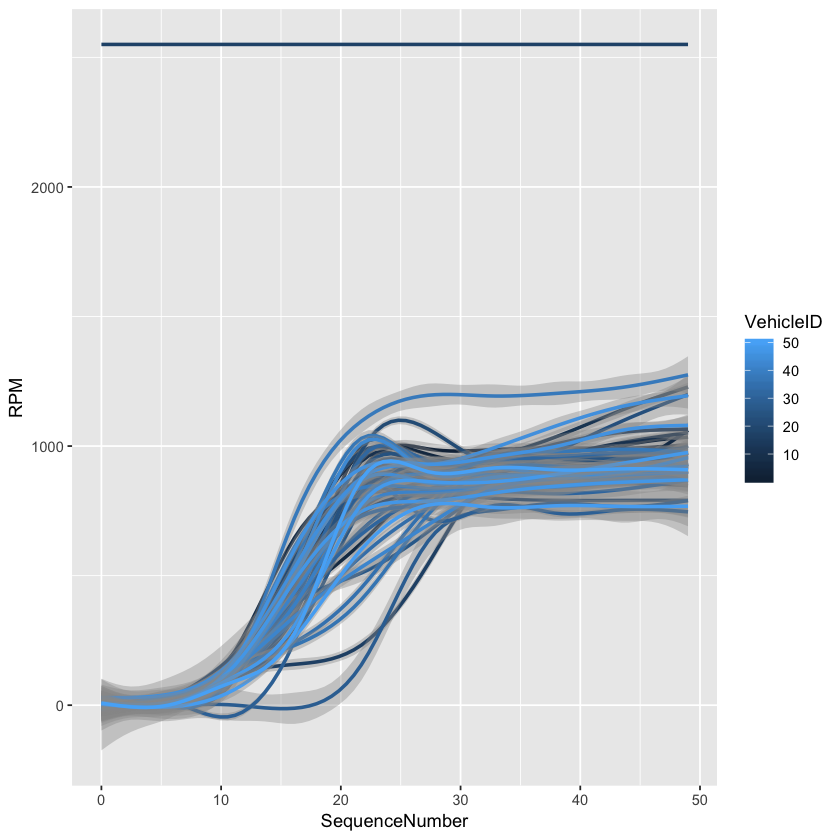

In [15]:
# plot a smooth line plot which averages engine crank pattern across vehicle
# the grey part is the standard error for each vehicle
plot <- ggplot(data = df, aes(x=SequenceNumber, y=RPM, group=VehicleID, colour=VehicleID)) + geom_smooth()
plot

Evidently there is a vehicle with RPM constantly around 2550, which should be removed (vehicle 17). This will be discussed further in Part 4 of this Section.

Removing this vehicle the figure looks as follows.

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'


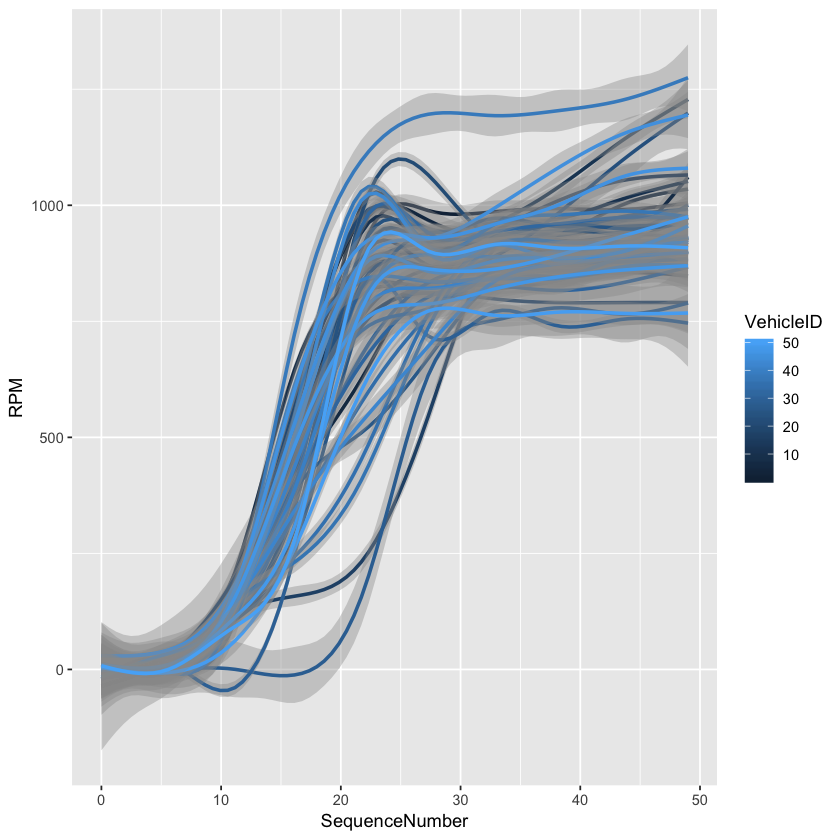

In [43]:
# remove vehicle 17
df <- df %>% filter(VehicleID != 17)

# make the same plot
plot <- ggplot(data = df, aes(x=SequenceNumber, y=RPM, group=VehicleID, colour=VehicleID)) + geom_smooth()
plot

The engine crank patterns observed are very similar to those shown in the figures in Section 1 Part 3. There is a low period of RPM (where the engine is not running) followed by a large positive increase in the RPM as the starter provides high torque input to start the engine, followed by maintenance or a slight dip in the RPM.

This aggregate graph does not illustrate individual engine crank patterns well. For that, we plot a line plot of every individual crank pattern.

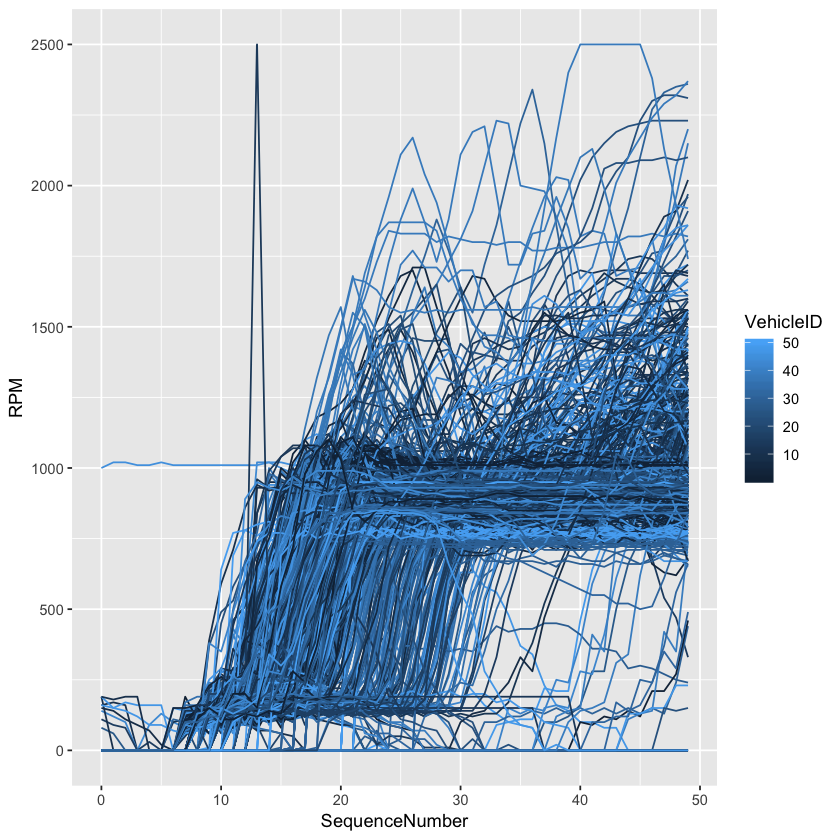

In [70]:
# create a line plot for each individual crank event
# it will look a little messy, but will give a much more detailed picture of the crank events occurring
plot3 <- ggplot(data = df, aes(x=SequenceNumber, y=RPM, colour=VehicleID, group=RawDataId)) + geom_line()

# plot the graph
plot3

# in reality I would create this plot with ggplotly, which allows you to hover over a line
# and identify the values, vehicle ID etc. Unfortunately this made the file size too large.
# the code would be: ggplotly(plot3)

As seen in the figure above, the general pattern is that from SequenceNumber 0-10 the RPM of the vehicle is low, followed by the expected positive increase in RPM. After this increase, there is a variety of trajectories for the RPM - some increase, some oscillate up and down.

One vehicle's crank pattern maintains a steady ~1000RPM, which seems to be an outlier, along with the crank pattern that peaks to 2500RPM at around SequenceNumber 13. These outliers will not currently be removed (they don't ruin the visualisation as vehicle 17 did) but will be discussed in Part 4 of this Section.

From the figure, most engines seem to start the crank event at SequenceNumber 6. Some crank events have a rise in RPM around SequenceNumber 10 whereas others undergo this change around SequenceNumber 30. This demonstrates variations in the engine startup time, which will be discussed in Part 6 of this Section.

To look at individual vehicle engine crank patterns, the figure can be facet wrapped (i.e. broken down into graphs for each vehicle).

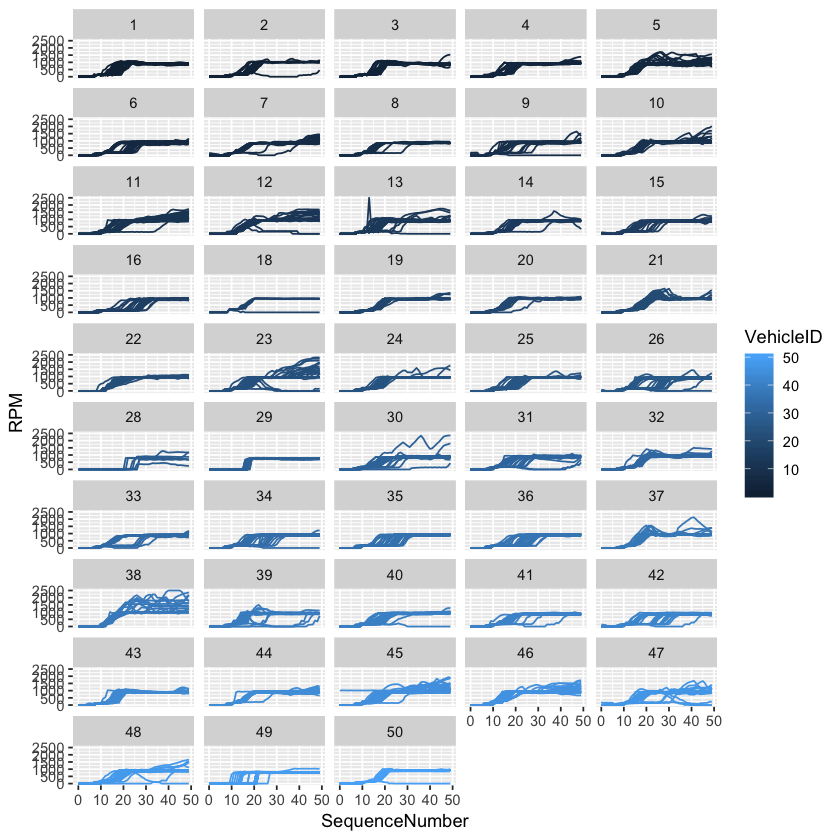

In [20]:
# facet wrap to observe engine crank patterns for each vehicle
plot3 + facet_wrap(facets=df$VehicleID, nrow = 10, ncol = 5)

The figure above shows that some vehicles have a variety of different engine crank patterns. For example, vehicle 29 has a consistent crank pattern including the rise and maintenance of RPM, whereas vehicle 38 has quite a consistent rise in RPM but that is followed by heavy fluctuations in RPM following engine start.

Some vehicles show a variety of start times, such as 35 and 36. These vehicles have the initial small increase in RPM, but the rise in RPM is sometimes slow or fast in occurring. This could be due to differences in temperature for each startup (given that temperature affects startup [4]), or perhaps may show a deterioration in the engine over time. These possibilities of relationships between variables are discussed in Part 7 of this Section.

Worryingly, some vehicles show patterns indicative of stalling or failed engine start. This is represented by an initial rise in RPM followed by a decrease back to lack of motion. This is most clearly seen for vehicle 47. Engine stalls will be discussed shortly.


### 3. Common Patterns - Voltage

During engine startup, voltage is expected to dip at the initial engagement of the starter motor [4] (see Figure below).

<img src="Waveforms.png" alt="Waveforms" width="500" height="500"/>

This characteristic dip in voltage is observed in the vehicles. Showing voltage patterns for all 50 vehicles is a bit too messy to be useful, but it is best observed in vehicle 3 (below).

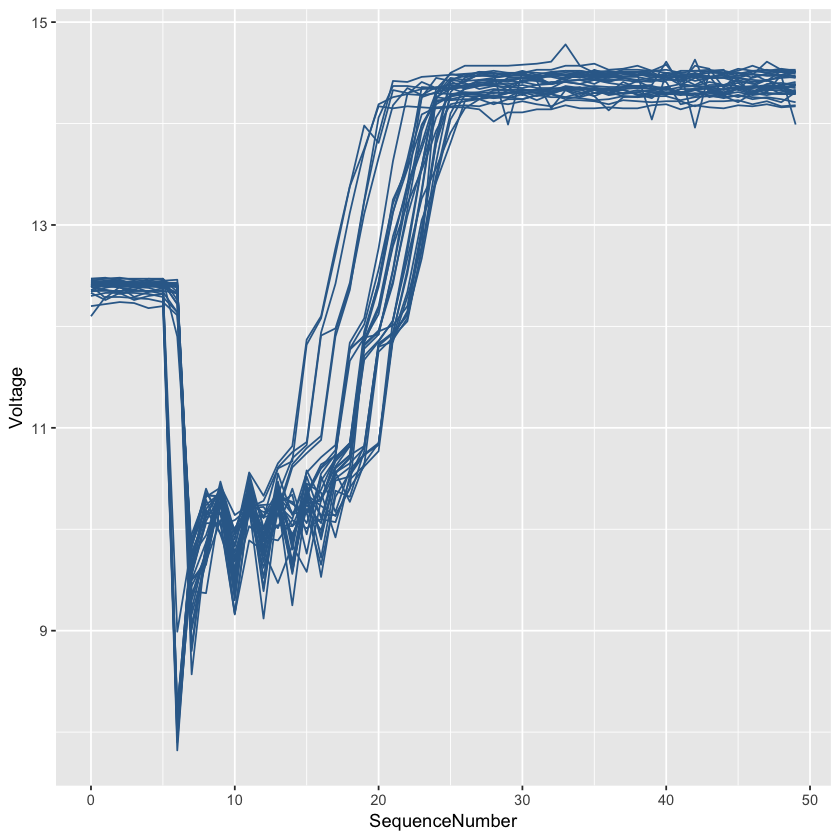

In [67]:
# filter to get data for vehicle 3 only
volt_3 <- df %>% filter(VehicleID == 3)

# create a line plot for voltage patterns
carvolt3 <- ggplot(data = volt_3, aes(x=SequenceNumber, y=Voltage, colour=VehicleID, group=RawDataId)) +
    geom_line() +
    theme(legend.position="none")
carvolt3

Voltage seems to dip around SequenceNumber 6, which relates to the RPM in earlier figures first increasing at the same SequenceNumber.

This correspondence is more easily understood when visualised (below). The figure shows a dip in voltage at Sequence Numbers 6 and 7, which corresponds with the initial increase in RPM at the same Sequence Numbers.

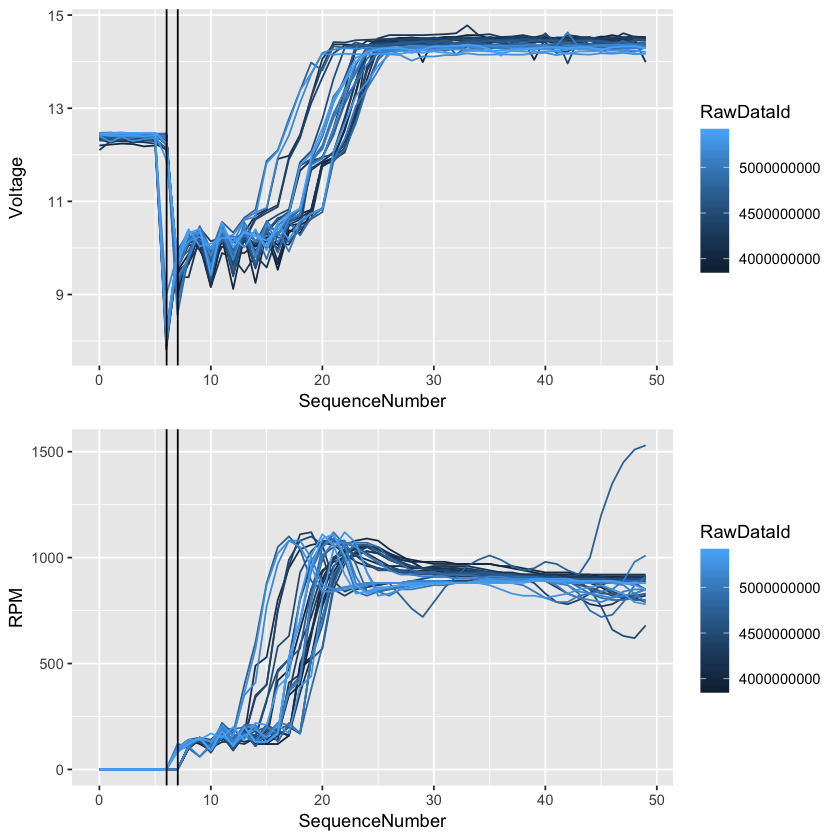

In [48]:
# plot the voltage line graph for vehicle 3
plot_volt3 <- ggplot(data = volt_3, aes(x=SequenceNumber, y=Voltage, colour=RawDataId, group=RawDataId)) + geom_line() + geom_vline(xintercept = 6.03) + geom_vline(xintercept = 7.03)

# plot the RPM line graph for vehicle 3
plot_rpm3 <- ggplot(data = volt_3, aes(x=SequenceNumber, y=RPM, colour=RawDataId, group=RawDataId))  + geom_line() + geom_vline(xintercept = 6.03) + geom_vline(xintercept = 7.03)

# create a new grid and put both plots aligned one above the other
grid.newpage()
grid.draw(rbind(ggplotGrob(plot_volt3), ggplotGrob(plot_rpm3), size = "last"))

### 4. False Positive Engine Cranks

### &nbsp;&nbsp;&nbsp;&nbsp;4.1. Incorrect Recordings  

As mentioned in the brief, there are some issues with false positive recordings. This occurred for every observation of vehicle 17 as discussed above, where the RPM was constantly at 2550.

Additionally, vehicle 45 has an observation where the RPM remains at around 1000RPM throughout (below). This is taken to be a false positive recording also.

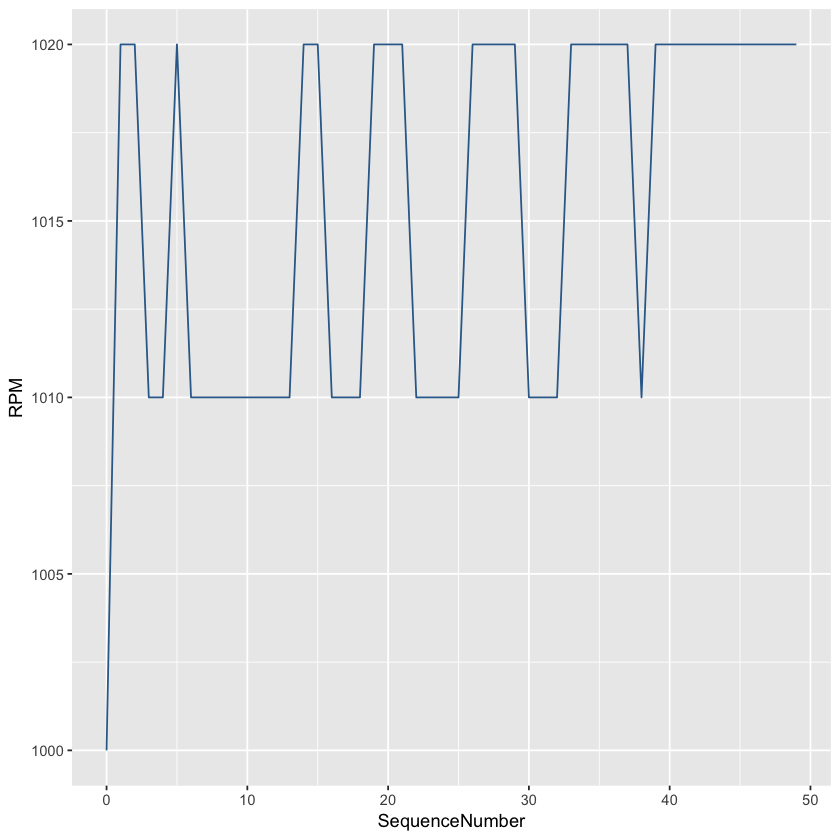

In [66]:
# select the particular engine crank event
flat1000 <- df %>% filter(RawDataId == 4390150868)

# create a line plot for that event
plotflat <- ggplot(data = flat1000, aes(x=SequenceNumber, y=RPM, colour=VehicleID, group=RawDataId)) +
    geom_line() +
    theme(legend.position="none")
plotflat

Another concern is in an engine crank observation of vehicle 13, where there is an unrealistic spike to 2500RPM (below). Given that this is likely an incorrect observation, this crank event will be removed. There are other means of dealing with this outlier but removal is most feasible given the context.

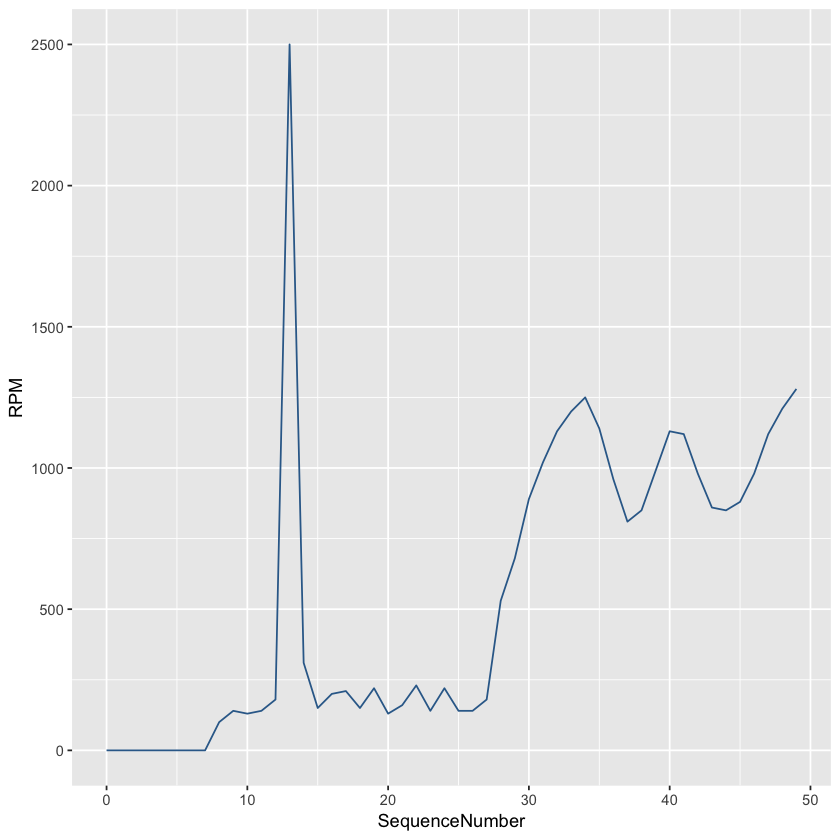

In [65]:
# get individual data for the spike of vehicle 13
spike13 <- df %>% filter(RawDataId == 5272677670)

# create a line plot for this engine crank event
spikeplot <- ggplot(data = spike13, aes(x=SequenceNumber, y=RPM, colour=VehicleID, group=RawDataId)) +
    geom_line() +
    theme(legend.position="none")
spikeplot

These false observations are removed below.

In [56]:
# create new dataframe removing erroneous observations
df_filtered <- df %>% 
  filter(RawDataId != 5272677670) %>%
  filter(RawDataId != 4390150868) %>% 
  filter(VehicleID != 17)

### &nbsp;&nbsp;&nbsp;&nbsp;4.2. Engine Stalls

The most obvious false positive observations are those where there are engine stalls or failures to start. As defined above, 500RPM is considered to be the cutoff where a successful engine start can be considered to have taken place. Given the figures above, it seems best to define an engine stall as an RPM less than 500 at the final SequenceNumber.

These stalls can be identified quite simply.

In [59]:
# use the dataframe with erroneous observations removed
stalls <- df_filtered %>% 
# get data for the final sequence
  filter(SequenceNumber == 49) %>%
# keep all data where RPM is less than 500
  filter(RPM < 500)

suppressWarnings(describe(stalls))

,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
VehicleID,1,22,27.27273,14.346667,24.50,27.27778,16.308600,2.00,50.00,48.00,0.15991941,-1.2363385,3.0587196
RawDataId,2,22,4577962422.90909,497906180.882013,4686674865.50,4574485787.83333,704443676.691300,3885993473.00,5383382511.00,1497389038.00,-0.01259562,-1.5541461,106153954.4419314
SequenceNumber,3,22,49.00000,0.000000,49.00,49.00000,0.000000,49.00,49.00,0.00,NaN,NaN,0.0000000
DateTime*,4,22,NaN,NA,NA,NaN,NA,Inf,-Inf,-Inf,NA,NA,NA
Voltage,5,22,12.03273,2.926197,11.83,11.56111,0.800604,9.58,24.54,14.96,3.47235924,12.2249725,0.6238673
RPM,6,22,106.36364,174.343543,0.00,77.22222,0.000000,0.00,490.00,490.00,1.16070829,-0.3103691,37.1701683
Temp,7,22,11.13636,7.704640,12.00,11.44444,8.154300,-7.00,25.00,32.00,-0.40638725,-0.3655610,1.6426347


The table above shows that there are 22 stalled crank events. 

The plot below shows all stalled crank events.

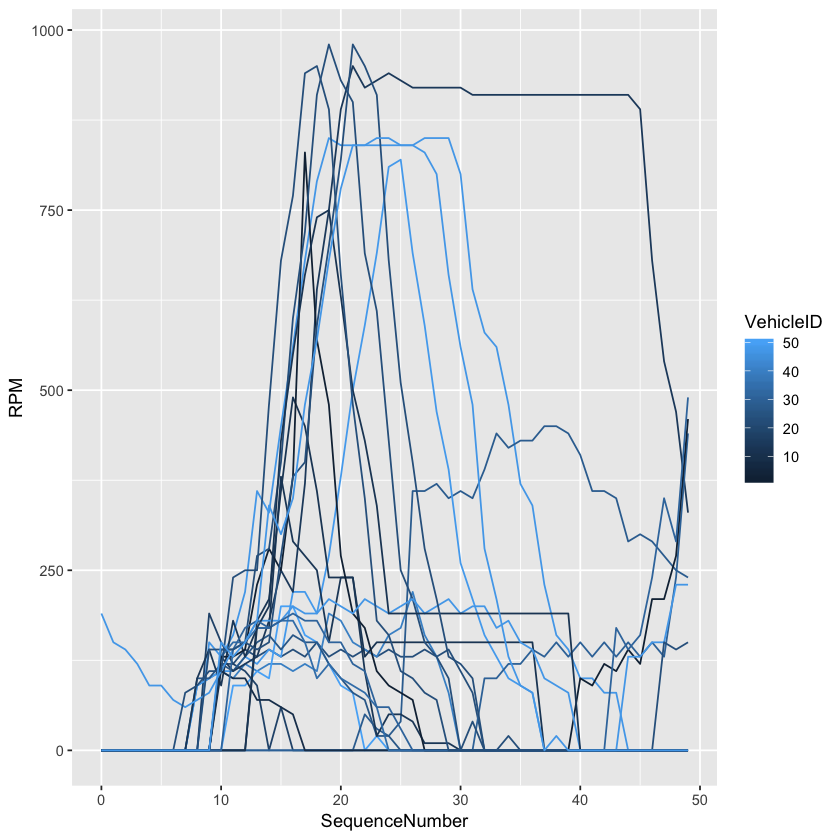

In [64]:
# get only the data where there is a stalled crank event
stalldf <- df_filtered %>% filter(RawDataId %in% stalls$RawDataId)


# plot all stall events
stallsplot <- ggplot(data = stalldf, aes(x=SequenceNumber, y=RPM, colour=VehicleID, group=RawDataId)) + geom_line() 
stallsplot

All stalled crank events can be removed from the data so that we have reasonably clean data with which to do some exploratory analysis. There are a variety of ways to deal with such a situation, but removal seems most feasible given the context. In reality, I would discuss this part in great detail with a collaborator before reaching agreement based on how to move forward, keeping as much data as possible whilst still avoiding erroneous observations and unrealistic outliers.

In [63]:
# create a new logical operator that is the opposite of %in%
'%ni%' <- Negate('%in%')

# filter the dataframe to create the cleaned version of the dataset
df_clean <- df_filtered %>% filter(RawDataId %ni% stalls$RawDataId)

### 5. Measurement Latency and Partial Crank Patterns  

In terms of partial crank patterns mentioned in the brief, it is possible that these partial patterns are observed in the stalled crank event graph. As can be seen, some crank events have an increase in RPM towards the end of the sequence, such that it looks as though the engine is about to successfully start. 

It is unclear whether this is the case, given the lack of data past sequence 49. In my opinion, some of the stalled crank events observed above may in fact simply be late recordings of crank events, where the recording has begun too far in advance of the actual crank event. The relates to the brief, where latency of recordings is brought up as a concern.

In either case, removal of those crank events should in theory remove the issues of: false positive recordings, stalls, and latency-error observations.

### 6. Engine Startup Times

Given that the start of the crank event can be identified (when RPM passes 0), and the criterion for a successful startup crank event is known (when RPM passes 500), the length of an engine startup event can be identified based on crank event data. This startup time would be the length of time between passing 0 RPM and passing 500 RPM.

Startup times are calculated below.

In [72]:
# create a dataframe that shows when each crank event passes 0RPM
# group_by RawID so each crank event is manipulated individually
# filter to get all RPM over 0
over_zero_df <- df_clean %>% group_by(RawDataId) %>% filter(RPM > 0) %>% 
# get the minimum sequence number for each crank event (i.e. the first time RPM passes above 0)
  summarise(start = min(SequenceNumber))

# create a dataframe that shows when each crank event passes 500RPM
# group_by RawID so each crank event is manipulated individually
# filter to get all RPM over 500
over_500_df <- df_clean %>% group_by(RawDataId) %>% filter(RPM > 500) %>% 
# get the minimum sequence number for each crank event (i.e. the first time RPM passes above 500)
  summarise(finish = min(SequenceNumber))

# join the start and finish dataframes onto the main dataframe
clean_plus_start_finish_df <- df_clean %>% 
  full_join(over_zero_df) %>% 
  full_join(over_500_df)

# create a time difference variable to observe how long each car takes to start for each crank event
clean_full_time_difference <- clean_plus_start_finish_df %>% 
  mutate(sequence_diff = finish - start) %>% 
  # multiply sequence difference by 0.1 because each sequence is 0.1 seconds
  mutate(time_to_start = sequence_diff*0.1) 

# this has created a startup time variable for each crank event (below)

head(clean_full_time_difference)

Joining, by = "RawDataId"
Joining, by = "RawDataId"


VehicleID,RawDataId,SequenceNumber,DateTime,Voltage,RPM,Temp,start,finish,sequence_diff,time_to_start
16,3886212242,0,2015-02-01 03:52:22,12.84,0,1,8,30,22,2.2
16,3886212242,1,2015-02-01 03:52:22,12.80,0,1,8,30,22,2.2
16,3886212242,2,2015-02-01 03:52:22,12.82,0,1,8,30,22,2.2
16,3886212242,3,2015-02-01 03:52:22,12.85,0,1,8,30,22,2.2
16,3886212242,4,2015-02-01 03:52:22,12.42,0,1,8,30,22,2.2
16,3886212242,5,2015-02-01 03:52:22,12.43,0,1,8,30,22,2.2


Startup time is a repeated value over each crank event.

One can get a table which shows average startup time per vehicle.

In [76]:
# get a single row from each crank event (since the values are repeated)
startuptime <- clean_full_time_difference %>% filter(SequenceNumber == 0) %>% 
  group_by(VehicleID) %>% 
# get average start time for each vehicle
  summarise(AverageStartTime = mean(time_to_start))

# spread this wide, rather than having to scroll down through it
wide_start_df <- spread(startuptime, key = VehicleID, value = AverageStartTime)

# print the wide dataframe (not all will be shown if using Jupyter)
wide_start_df

1,2,3,4,5,6,7,8,9,10,⋯,41,42,43,44,45,46,47,48,49,50
1.009677,0.9933333,1.022581,0.8258065,0.7290323,1.116129,0.8387097,0.7225806,0.9586207,0.8290323,⋯,0.9322581,1.354839,0.9580645,0.7419355,0.8266667,0.7,0.956,0.9166667,0.003225806,0.9172414


Vehicle 49 interestingly has a start time near 0 seconds. Plotting this out shows that the increase in RPM is exceptionally fast.

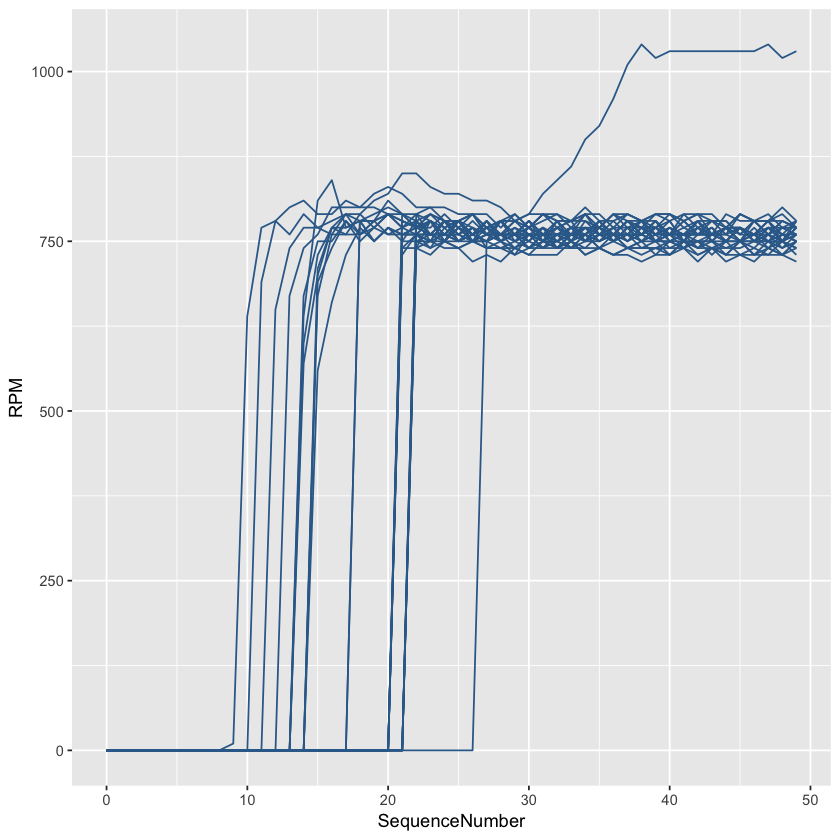

In [78]:
# get only data for vehicle 49
df_49 <- df %>% filter(VehicleID == 49)

# plot the line graph for 49
plot49 <- ggplot(data = df_49, aes(x=SequenceNumber, y=RPM, colour=VehicleID, group=RawDataId)) +
    geom_line() +
    theme(legend.position="none")
plot49

Vehicle 16 seems to have a very long startup time. The plot below helps illustrate this.

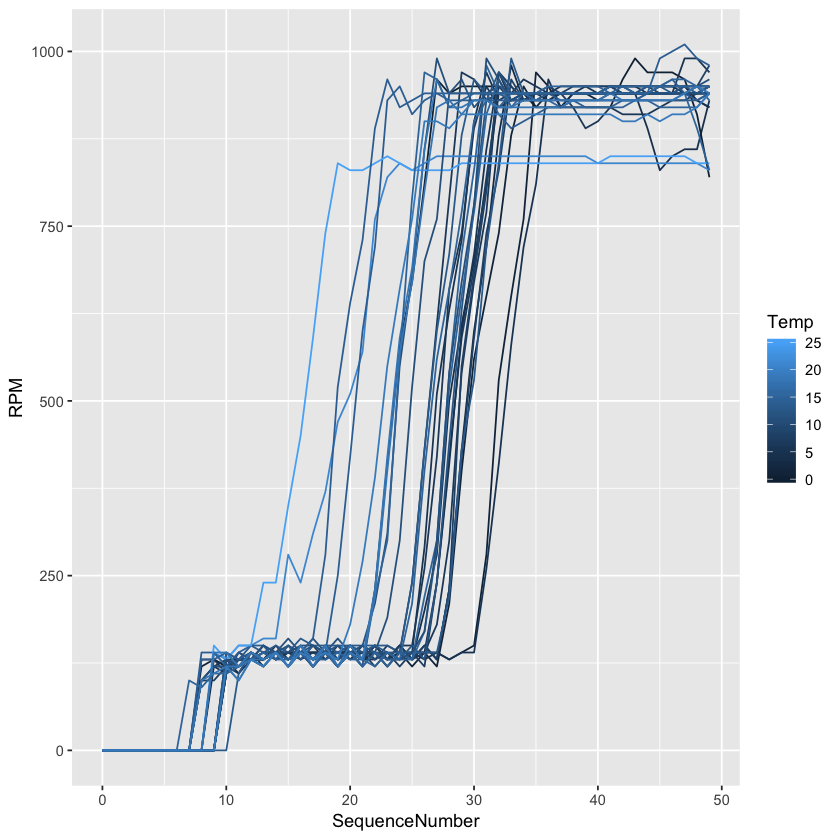

In [80]:
# get data for vehicle 16 only
df_16 <- clean_full_time_difference %>% filter(VehicleID == 16)

# plot vehicle 16's RPM data based on temperature
plot16 <- ggplot(data = df_16, aes(x=SequenceNumber, y=RPM, colour=Temp, group=RawDataId)) + geom_line() 
plot16

Above, Vehicle 16's crank event patterns are plotted, with the colour of the line showing temperature. It seems that vehicle 16 has a startup time that is quite strongly affect by temperature. The below scatterplot shows this relationship more clearly. The relationship between temperature and event crank pattern will be considered in Part 8 of this Section.

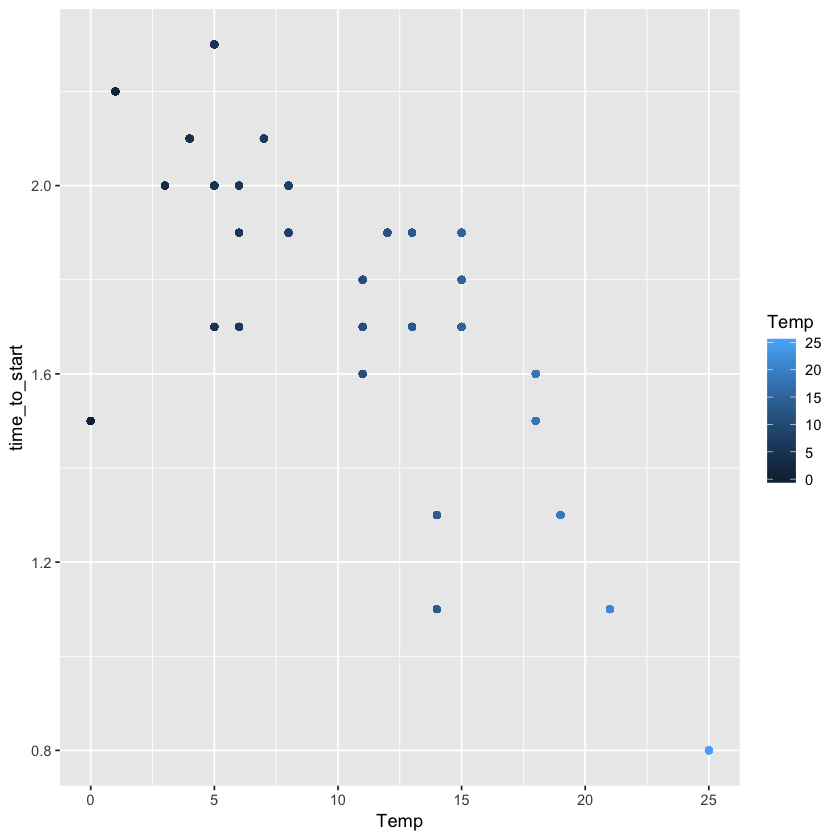

In [81]:
# plot vehicle 16's startup time versus temperature
plot16_2 <- ggplot(data = df_16, aes(x=Temp, y=time_to_start, colour=Temp, group=RawDataId)) + geom_point() 
plot16_2

### 7. Patterns Across Crank Event Variables

This part of the analysis aims to explore relationships between variables in the dataset. Given the exploratory nature, a reasonable first step is might have been to correlate all key variables to see whether any relationships are present, but since the dataset is so large, just about all correlations come out as statistically significant. Instead, plotting variables that are theoretically related is a good start to understand possible underlying relationships.

Here I present the most interesting plots found during exploration.

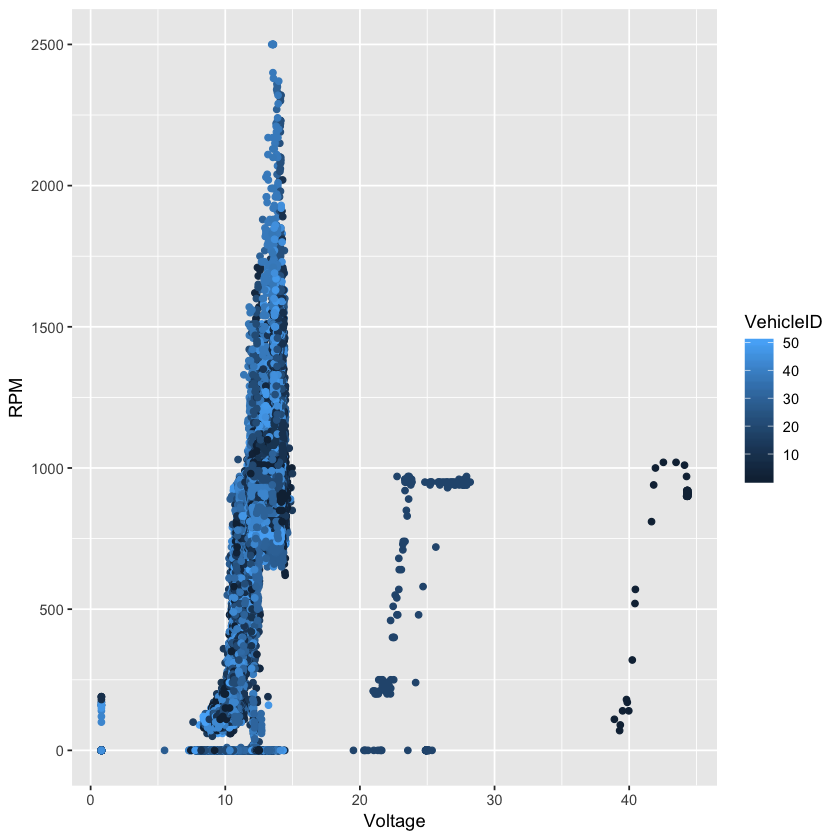

In [83]:
# voltage versus RPM

# plot voltage vs RPM
voltRPM <- ggplot(data = clean_full_time_difference, aes(x=Voltage, y=RPM, colour=VehicleID, group=RawDataId)) + geom_point() 
voltRPM

The above plot of voltage vs RPM identifies that vehicles 1 and 18 seem to be functioning at voltages different to the other vehicles. This suggests that perhaps they are a different vehicle type, or are functioning incorrectly. 

With these vehicles removed, the plot identifies a relationship between higher voltage and higher RPM.

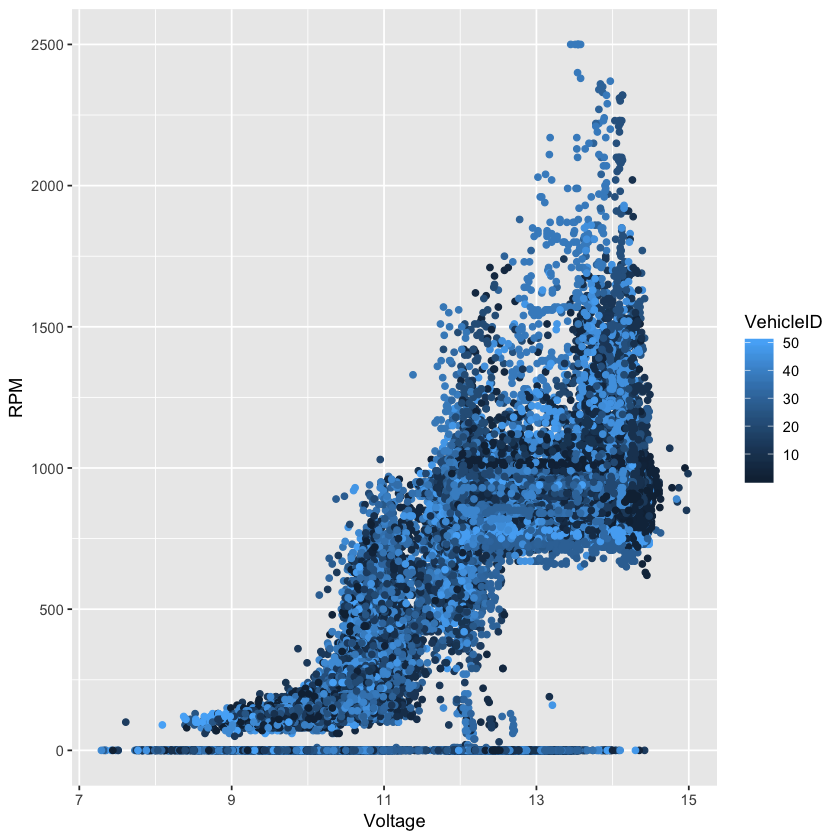

In [84]:
# remove outliers at upper and lower end of voltage
corr_df_voltage <- clean_full_time_difference %>% filter(Voltage < 18 & Voltage > 7) 

# plot voltage vs RPM
voltRPM2 <- ggplot(data = corr_df_voltage, aes(x=Voltage, y=RPM, colour=VehicleID, group=RawDataId)) + geom_point() 
voltRPM2

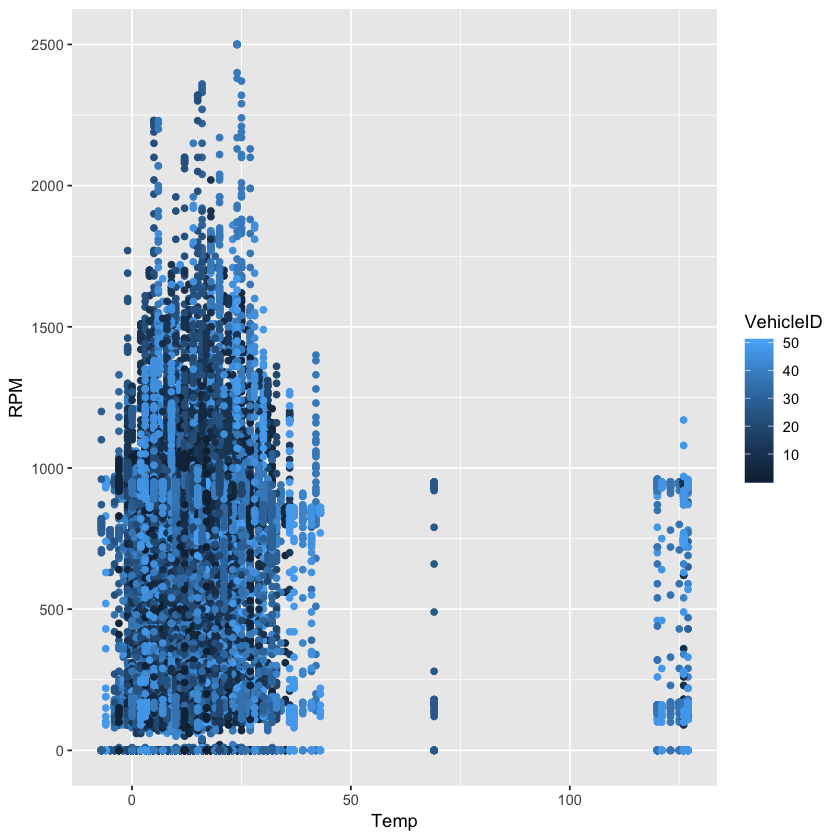

In [86]:
# RPM versus Temperature

RPMTemp <- ggplot(data = clean_full_time_difference, aes(x=Temp, y=RPM, colour=VehicleID, group=RawDataId)) + geom_point() 
RPMTemp

The above plot of Temp vs RPM indicates that some vehicles are undergoing crank events at around 70 and 125 degrees Celcius. It is unclear whether this is due to faults, differences in vehicle type, or some other variable. Additionally, the high temperature could be due to the vehicle having been recently used, which of course would lead to a temperature increase.

These interesting patterns of outliers for different variables suggests that it would be unwise to move to further data analysis without first thoroughly checking assumptions and speaking with an engineer to identify whether these values are normal.

# 3. Identifying Methods for Determining Engine Crank Pattern (Q3)

### 1. Sequence/Process Analysis

Sequence analysis is usually used to identify chronological patterns in categorical data [5]. A good example is that of an individual's route through the education and employment system. They will pass through categorical stages - nursery, primary, secondary, college, employment or university, and then perhaps higher education or employment. 

There are various visualisations that can come from sequence analysis [6]. Below shows a common visualisation - it identifies and shows the 10 most common sequences in a set of data on youth education/employment.

<img src="sequence.png" alt="SequenceImage" width="700" height="700"/>

The present dataset is not in a format suitable for sequence analysis, but it could be manipulated so that sequence analysis could take place. In terms of RPM, the following seems to be the most common sequence: begin at 0RPM, small increase in RPM, maintenance of that RPM for .5 seconds, sharp increase to around 1000RPM, maintenance of around 1000RPM.

The data could be cleaned so that sections of the crank event sequence could be categorised. Sequence analysis may yield interesting results, perhaps identifying what events happen prior to a stall or successful crank event.

Recommended R packages:
* TraMineR - "Life Trajectory Miner for R" the best sequence analysis package, useful for visualisations in table form  
https://cran.r-project.org/web/packages/TraMineR/vignettes/TraMineR-state-sequence.pdf
* bupar - "Business Process Analysis in R" contains several sub-packages that could supplement a sequence analysis approach. It has useful visulations in flow chart form, such as below  
http://www.bupar.net

<img src="process.png" alt="BUPARImage" width="700" height="300"/>

### 2. Change Point Detection

Change point detection is a useful approach for detecting changes in data, particularly abrupt ones such as the decreases in voltage and increases in RPM within the present dataset [7, 8]. The process seem robust even with noisy data, as seen below [9].

<img src="change.png" alt="ChangeDetection" width="500" height="500"/>

Approaches to change point detection range from parametric and non-parametric (as in the package CPM), to Bayesian (as in the package BCP). Each change point detection approach leads to reasonably similar results, as shown in the image above, which compares change point detection for three packages - CPM, BCP and ECP. This can also be integrated with Tableau.

Recommended R packages:
* CPM - "Sequential and Batch Change Detection Using Parametric and Nonparametric Methods"  
https://cran.r-project.org/web/packages/cpm/cpm.pdf
* BCP - "Bayesian Analysis of Change Point Problems" - Bayesian approach  
https://cran.r-project.org/web/packages/bcp/bcp.pdf
* changepoint.mv - "Changepoint Analysis for Multivariate Time Series" - base R package  
https://cran.r-project.org/web/packages/changepoint.mv/changepoint.mv.pdf

### 3. Time Delay Neural Network (TDNN)

Rather than post-hoc analysis, a Time Delay Neural Network (TDNN) uses values from a previous time-window (which can be changed for optimisation) to predict current/future values. For example, previous weather patterns over a window of 2-4 months can be used to predict future weather patterns [10].

Within the crank event dataset, voltage, RPM and temperature at within a time-window of perhaps .5-1 seconds could be used to predict various crank event patterns such as success or stalls.

There is no TDNN specific package in R, which is expected. Neural networks have certain variables that can be changed to create different kinds of neural networks (e.g. convolutional, time-delay, recurrent). In creating a TDNN for this event crank data, the input would simply have to be a previous time-window in relation to the event or values in question.

Somewhat related to the TDNN is the Nonlinear Autoregressive Exogenous Model (NARX), which also generally uses past-data to predict present values [11]. The R package for it is called tsDyn.

Recommended R packages:
* Keras - recommended because it can run on top of TensorFlow, Theano or CNTK, popular yet more complex deep-learning packages. Due to its widespread use and simplicity, it has good user-support both in documentation and forums such as stackoverflow.  
https://keras.io

### 4. Decision Tree / Random Forest

A decision tree is a logical flow chart where data can be organised into different categories based on its route through the tree [12]. A random forest is a generally more robust procedure, where variations on decision tree structures are used, and the outcome of a group of decision trees are aggregated to come up with an outcome or categorisation (the forest being of course, a group of trees)[13].

A decision tree or random forest may be able to identify engine crank pattern based on a number of factors, such as start RPM, end RPM, startup time, average RPM, voltage, temperature, and so on. This could even use certain categorisations such as 'event contains a sudden increase in RPM' which would be expected for successfull crank events.

Recommended R packages:
* rpart - "Recursive Partitioning and Regression Trees" simple to use, quite well documented and supported  
https://cran.r-project.org/web/packages/rpart/index.html

### 5. Locally Weighted Scatterplot Smoothing

Locally Weighted Scatterplot Smoothing (LOWESS or sometimes LOESS) is a method of identifying a smooth line across data [14].

<img src="loess.png" alt="LoessFigure" width="500" height="500"/>

This would be exceptionally useful for both the voltage and RPM patterns in the crank event data. In fact, this is the method used in any geom_smooth() function in ggplot2 in R. It does not seem to afford output statistics, but is very useful at identifying patterns at a glance, which might be useful for a graphical user interface (GUI).

### 6. Various Types of Regression

Multiple regression is useful for identifying interactions between variables, often identifying interactions not clear through visualisation methods [15]. Given that there are several key variables (RPM, temp, voltage) it would be useful and probably most simple if a multiple regression were run to identify interactions.

Although reasonably robust, there are some key assumptions of multiple regression [16], and based on the visualisations it is possible that these assumptions will not be met by the crank event data. In such a case, data manipulation/transformation could help the data to meet assumptions. The RPM data observes a curve sometimes known as an 'easeinout' curve, which may have a corresponding transformation function to ensure that it is linear.

Logistic regression is useful if one hopes to categorise data [17], and it may be useful to categorise crank events as successful, delayed-observation, or stalled.

Additionally, a time-delayed multiple regression may offer predictive power, by using a past time-window of data to predict current/future values [18], much the same as TDNN or NARX. This could have possible real-time applications such as predicting a fault before it occurs, either within a crank event, or across a multitude of crank events (i.e. predicting deterioration of a vehicle).

# 4. Recommendations 

### Check Assumptions

As mentioned previously, there are multiple assumptions worth checking before moving forward with full analysis. Exploratory analysis above has shown that some of these assumptions may not be met. For example, vehicles 1 and 18 seem to be functioning at different voltages to the other vehicles. Although this could perhaps be taken into account post-hoc, it would be better to have vehicle type as an actual variable. 

Additionally, it would be worthwhile checking with an engineer that some of the recordings are as expected. For example, there are some temperature and RPM outliers and it is unclear whether these are erroneous or plausible.

### Seek Additional Variables

Alongside gaining information about vehicle type, it may be useful gaining a few more pieces of information to take into account.

The additional variables I believe would be most useful are: 1) whether the vehicle has recently been in use or not; 2) what other parts of the vehicle may be in use at time of startup (to help to account for voltage variation); 3) key engine parameters such as size, expected voltage at startup; 4) expected RPM after startup. 

Further, a camshaft position sensor can offer additional information on the crank event, which may help to prevent false positive recordings and add to the validity of observations. 

These variables may be useful in helping one to explain various crank events. It is possible that none of these variables can be obtained, but it is worth checking.

### Battery State-of-Health (SOH)

A battery's State-of-Health (SOH) can be identified based on voltage patterns during crank events [4]. If the minimum voltage at first engagement of the starter (V1) is greater than the minimum voltage between initial start and 500 RPM (V2), this battery is considered to have low power [4](see below).

<img src="lowpower.png" alt="LowPowerGraph" width="300" height="600"/>

If the minimum voltage at first engagement of the starter (V1) is less than the minimum voltage between initial (T1) start and 500 RPM (V2), this battery is considered to have high power [4](see below).

<img src="highpower.png" alt="HighPowerGraph" width="300" height="600"/>

Since this is not particularly challenging to calculate, it is something worth considering as an extra option for analysis.

### Relation of Crank Event to SOC

Although not a specific question (Q1-Q3), the brief mentions that further stages of the task would be to identify how SOC can be predicted based on crank event patterns. In Section 4 above (Methods for Determining Engine Crank Pattern), it is possible to change the input and outputs of each of the data analysis methods, such that crank event could be the predictor variable and SOC the output variable. This may be a useful starting point, and since the methods may be used to identify crank event patterns, the model inputs and outputs may easily be manipulated, rather than creating new models in their entirety.

# 5. Concluding Remarks

This paper has summarised the data regarding crank events identified numerous crank event patterns (Q1, Q2), and has identified several viable methods for identifying crank event patterns.

To conclude, the dataset shows typical crank event patterns on startup of a vehicle, though it does include some false positive observations and a few stalls. Before moving to full data analysis based on the methods suggested, I recommend checking several key assumptions.

Data analysis may allow for prediction of SOC based on crank event, prediction of deterioration of a vehicle, identification of the relationship between variables, alongside predicting stall events and successful engine crank events.

## 6. References

[1] Yu, B. Y., Feng, Q. K., & Yu, X. L. (2013). Dynamic simulation and stress analysis for reciprocating compressor crankshaft. Proceedings of the Institution of Mechanical Engineers, Part C: Journal of Mechanical Engineering Science, 227(4), 845-851. DOI: https://doi.org/10.1177/0954406212453523  
[2] Hall, H. (2015) Engine power train. Retrieved from https://www.grc.nasa.gov/WWW/K-12/airplane/powert.html  
[3] Chowanietz, E. (1995). Automobile Electronics. London: Reed Elsevier.  
[4] Grube, R. J. (2008). Automotive battery state-of-health monitoring methods (Doctoral dissertation, Wright State University).  
[5] Abbott, A. (1995). Sequence analysis: new methods for old ideas. Annual review of sociology, 21(1), 93-113.  
[6] Gabadinho, A., Ritschard, G., Muller, N.S. & Studer, M. (2011). Analyzing and visualizing state sequences in R with TraMineR. Journal of Statistical Software, 40(4), 1–37. DOI https://doi.org/10.18637/jss.v040.i04  
[7] Gustafsson, F. (1996). The marginalized likelihood ratio test for detecting abrupt changes. IEEE Transactions on Automatic Control 41(1), 66–78.  
[8] Liu, S., Yamada, M., Collier, N., & Sugiyama, M. (2013). Change-point detection in time-series data by relative density-ratio estimation. Neural Networks, 43, 72-83.  
[9] Data * Science + R (2015) Change point detection in time series with R and Tableau. Retrieved from https://www.r-bloggers.com/change-point-detection-in-time-series-with-r-and-tableau/  
[10] Benmahdjoub, K., Ameur, Z., & Boulifa, M. (2013). Forecasting of rainfall using time delay neural network in Tizi-Ouzou (Algeria). Energy Procedia, 36, 1138-1146.  
[11] Pham, H. T., & Yang, B. S. (2010). A hybrid of nonlinear autoregressive model with exogenous input and autoregressive moving average model for long-term machine state forecasting. Expert Systems with Applications, 37(4), 3310-3317.  
[12] Safavian, S. R., & Landgrebe, D. (1991). A survey of decision tree classifier methodology. IEEE transactions on systems, man, and cybernetics, 21(3), 660-674.  
[13] Liaw, A., & Wiener, M. (2002). Classification and regression by randomForest. R news, 2(3), 18-22.  
[14] Cleveland, W. S. (1979). Robust locally weighted regression and smoothing scatterplots. Journal of the American statistical association, 74(368), 829-836.  
[15] Aiken, L. S., West, S. G., & Reno, R. R. (1991). Multiple regression: Testing and interpreting interactions. Sage.  
[16] Osborne, J., & Waters, E. (2002). Four assumptions of multiple regression that researchers should always test. Practical assessment, research & evaluation, 8(2), 1-9.  
[17] Hosmer Jr, D. W., Lemeshow, S., & Sturdivant, R. X. (2013). Applied logistic regression (Vol. 398). John Wiley & Sons.  
[18] Gonzalez, R., & Catania, C. A. (2016, April). Time-delayed multiple linear regression for increasing MEMS inertial sensor performance by using observations from a navigation-grade IMU. In 2016 IEEE/ION Position, Location and Navigation Symposium (PLANS) (pp. 15-20). IEEE.  